# Showcase of single experiment.

The purpose of this notebook is to visualize and understand how a single experiment is performed using optimal model.

In [194]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from matplotlib import pyplot as plt

import logging

In [195]:
# path to cleaned data file
dataFilePath = 'data/data_clean.pkl'
trainFilePath = 'data/data_train.pkl'
testFilePath = 'data/data_test.pkl'

In [196]:
# Read already prepared and saved data
with open(dataFilePath, 'rb') as f:
    data = pickle.load(f)

# Read already prepared and saved train/test datasets
with open(trainFilePath, 'rb') as f:
    data_train = pickle.load(f)

with open(testFilePath, 'rb') as f:
    data_test = pickle.load(f)

In [197]:
# Create dummy variables for categorical data
data_train = pd.get_dummies(data_train, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_test = pd.get_dummies(data_test, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])

In [198]:
print('Shape of train: ', data_train.shape, '\n')
print('Columns of train: ', data_train.columns, '\n')
print('Shape of test: ', data_test.shape, '\n')
print('Columns of test: ', data_test.columns, '\n')

Shape of train:  (1251, 40) 

Columns of train:  Index(['age', 'psa', 'biopsy_gleason', 'survival_months', 'pathologic_gleason',
       'survival_months_bcr', 'survival_months_mts', 'patient_id', 'bcr',
       'mts', 'death_from_other_causes', 'cancer_specific_mortality',
       'clinical_stage_1', 'clinical_stage_2', 'clinical_stage_3',
       'biopsy_gleason_gg_1', 'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3',
       'biopsy_gleason_gg_4', 'biopsy_gleason_gg_5',
       'pathological_gleason_gg_1', 'pathological_gleason_gg_2',
       'pathological_gleason_gg_3', 'pathological_gleason_gg_4',
       'pathological_gleason_gg_5', 'pathologic_stage_0', 'pathologic_stage_1',
       'pathologic_stage_2', 'lni_0.0', 'lni_1.0', 'lni_unknown',
       'surgical_margin_status_0', 'surgical_margin_status_1',
       'persistent_psa_0', 'persistent_psa_1', 'TRYSgrupes_0', 'TRYSgrupes_1',
       'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1'],
      dtype='object') 

Shape of test:  (313, 40) 

Columns of te

First things first, as we have 4 response variable, will have to remove those variables from the feature set which will be fed into the training.  
For this experimentation, we'll focus on cancer specific mortality (target_column)

In [199]:
# List of columns names which will be dropped from feature set before fitting the model
target_columns = ['cancer_specific_mortality', 'death_from_other_causes', 'bcr', 'mts']
target_column = 'cancer_specific_mortality'

target_columns.remove(target_column)
df_train = data_train.copy().drop(target_columns, axis=1)
df_test = data_test.copy().drop(target_columns, axis=1)

Because our 2 response variables (mts and bcr) have different survival time column assigned, we'll determine which to use based on target_column:

In [200]:
# mts and bcr have different survival months columns
match target_column:
    case 'mts':
        time = 'survival_months_mts'
    case 'bcr':
        time = 'survival_months_bcr'
    case _:
        time = 'survival_months'

print(time)

survival_months


In [201]:
# we'll log some training execution informatio to a log file 
# to check if everything goes as expected
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='logs.log', mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [202]:
"""
Explodes the provided "df" dataset based on provided survival column "time" and
clips the data to be in a range [min_time; max_time] (). A new discrete survival column
will be created with name set as variable "time_discrete". "cum_event" boolean determines
if cumulative event column will be created or no.

clip(lower, upper) function will help us create a new discrete survival time column. 
If we specify lower=1 and upper=200, patients who experienced event earlier than 200th 
month will only have records till their event, on other side, if a patient survived past 
200th month, we will clip this information and will only keep information about him til 200th month.
Another example, if we specify lower=140 and upper=200, and if the person experienced event 
at 100th month, we will create records for him till 140th (lower boundary) month.
"""
def explode_data(df,max_time,time,target_column,min_time=1,
                 time_discrete='survival_time_discrete',cum_event=False):
    
    logging.info('Exploding the data......')
    logging.debug(f'Exploding will happen for target column: {target_column}')
    logging.debug(f'Data will be exploded with min {min_time} and max {max_time} survival times')
    logging.debug(f'Survival time range BEFORE exploding: min {df[time].min()}, max {df[time].max()}')

    target_column_discrete = target_column + '_discrete'

    # We create a new time column and clip the data by provided min and max survival times
    df[time_discrete] = df[time].clip(min_time,max_time).apply(range)

    # Exploding the dataset with the created range value in new time column
    data_exploded = df.explode(time_discrete)
    data_exploded.reset_index(drop=True, inplace=True)

    # New column starts at 0, we'll increase each value by 1
    data_exploded[time_discrete] = pd.to_numeric(data_exploded[time_discrete]) + 1
    logging.debug(f'Survival time range AFTER exploding: min {data_exploded[time_discrete].min()}, max {data_exploded[time_discrete].max()}')

    # New event column, which will indicate the last event date
    data_exploded[target_column_discrete] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded[target_column])
    
    if cum_event == True:
        logging.info('Cumulative event will be added.....')
        target_column_cumulative = target_column + '_cumulative'

        # Create new event column with duplicated event values from discrete column
        data_exploded[target_column_cumulative] = data_exploded[target_column_discrete]
        
        # For cumulative events, after end_time we will have NA values, we'll replace those with event indicator
        after_survival_time = data_exploded[time_discrete] > data_exploded[time]
        data_exploded.loc[after_survival_time, target_column_discrete] = -1
        data_exploded[target_column_discrete] = data_exploded[target_column_discrete].replace(-1,np.NaN)
        data_exploded.loc[(after_survival_time & (data_exploded[target_column]==0)), target_column_cumulative] = -1
        data_exploded[target_column_cumulative] = data_exploded[target_column_cumulative].replace(-1,np.NaN)

    return data_exploded


"""
Given an exploded dataset with instant mortality probabilities "event_probability_column"
and "id_column" for grouping (optional), cumulative hazard column will be calculated
"""
def cumulative_hazard(df, event_probability_column, id_column):
    data_copy = df.copy()
    logging.info('Starting calculated cumulative hazards......')
    if id_column is not None:
        logging.debug(f'Cumulative hazards will be grouped by: {id_column}')
        data_copy = data_copy[ [id_column, event_probability_column] ]
    else:
        logging.warning('Cumulative hazards will NOT be grouped by any ID column.')
        data_copy = data_copy[ [event_probability_column] ]
    data_copy['negative_log_prob'] = np.log( 1 - data_copy[event_probability_column] )
    if id_column is not None:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy.groupby(id_column)['negative_log_prob'].transform(pd.Series.cumsum))
    else:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy['negative_log_prob'].cumsum())
    return data_copy['cumulative_hazard']


"""
Given non exploded dataset, explodes the dataset based on "max_time", lower boundary for exploding
a dataset will be the same as upper, so for each patient we will create "max_time" records.
Adds predictend instant mortality probabilities as well as cumulative ones.
"""
def add_predict_probabilities(df, model, max_time, target_column, time, is_homogenous_dataset=False):
    logging.info('Starting addition of predicted probabilities......')

    df_exploded = explode_data(df, max_time=max_time, min_time=max_time, cum_event=True, time=time, target_column=target_column)

    x_columns_to_drop = [target_column, target_column+'_discrete', target_column+'_cumulative', 'survival_months', 'survival_months_bcr', 'survival_months_mts', 'patient_id']
    X_df = df_exploded.drop(x_columns_to_drop, axis=1)

    # probabilities
    y_pred = model.predict_proba(X_df)[:,1]
    df_exploded['mortality_instant_prob'] = y_pred

    # Cumulative hazard for each patient
    df_exploded['cumulative_hazard'] = cumulative_hazard(df_exploded,'mortality_instant_prob','patient_id')
    
    # TODO - homogenous dataset
    # if is_homogenous_dataset:
        
    #     # get adjustment parameters
    #     match target_column:
    #         case 'cancer_specific_mortality':
    #             pi_0 = pi_0_csm
    #             pi_1 = pi_1_csm
    #             rho_0 = rho_0_csm
    #             rho_1 = rho_1_csm
    #         case 'death_from_other_causes':
    #             pi_0 = pi_0_doc
    #             pi_1 = pi_1_doc
    #             rho_0 = rho_0_doc
    #             rho_1 = rho_1_doc
    #         case 'mts':
    #             pi_0 = pi_0_mts
    #             pi_1 = pi_1_mts
    #             rho_0 = rho_0_mts
    #             rho_1 = rho_1_mts
    #         case 'bcr':
    #             pi_0 = pi_0_bcr
    #             pi_1 = pi_1_bcr
    #             rho_0 = rho_0_bcr
    #             rho_1 = rho_1_bcr
    #         case _:
    #             pi_0 = None
    #             pi_1 = None
    #             rho_0 = None
    #             rho_1 = None
        
        
    #     # adjusted probabilities
    #     df_exploded['mortality_instant_prob_adjusted'] = \
    #         (df_exploded.mortality_instant_prob*(pi_1/rho_1)) / \
    #         ((1-df_exploded.mortality_instant_prob)*(pi_0/rho_0) + \
    #          df_exploded.mortality_instant_prob*(pi_1/rho_1))
        
    #     # Cumulative hazard for each patient (adjusted)
    #     df_exploded['cumulative_hazard_adjusted'] = cumulative_hazard(df_exploded,'mortality_instant_prob_adjusted','patient_id')
    
    return df_exploded


"""
Function to read a single experiment from file
"""
def read_experiment(model_name, target_column, max_time, is_homogenous_dataset=False, experiment_name=None):
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
        
    model_path = f'{main_path}/{target_column}/{max_time}/{model_name}'

    if experiment_name is None:
        model_path = model_path + '/defaultExperiment'
    else:
        model_path = model_path + f'/{experiment_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read auc statistic
    with open(f'{model_path}/auc_statistics.pkl', 'rb') as f:
        auc_stats = pickle.load(f)
    return model, auc_stats

In [203]:
# graphs
# Given exploded dataset, id of a patient and a target column plots cumulative and
# instant mortality plots of the given patient
def plot_single_patient(df, model_name, experiment_name, max_time, patient_id, target_column, target_title='Mortality', fix_axis=True, is_homogenous_dataset=False):
    if patient_id not in df['patient_id'].values:
        print(f'Patient {patient_id} is not in the dataset.')
        return
    
    # Subset of data for the given patient
    person = df[df['patient_id'] == patient_id]
    
    # Get the column indexes of required columns
    mortality_column_index = person.columns.get_loc(target_column)
    survival_column_index = person.columns.get_loc('survival_months')
    cumulative_haz_column_index = person.columns.get_loc('cumulative_hazard')
    instant_prob_column_index = person.columns.get_loc('mortality_instant_prob')
    max_time_value = person.survival_time_discrete.max()
    
    cumulative_mortality = person[person['survival_time_discrete'] == person.iloc[0,survival_column_index]].iloc[0,cumulative_haz_column_index]
    instant_mortality = person[person['survival_time_discrete'] == person.iloc[0,survival_column_index]].iloc[0,instant_prob_column_index]
    
    # Extract model name
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
    model_path = f'{main_path}/{target_column}/{max_time}/{model_name}/{experiment_name}'
    
    # Plot cumulative mortality of the given patient
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8, forward=True)
    ax.plot(person['survival_time_discrete'],person['cumulative_hazard'],
        alpha=0.6,color='k',drawstyle='steps-post', linewidth=3)
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='orange',linewidth=2, zorder=1)
        
    ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
    ax2.set_xlabel("Years")
    
    ax.set_xlabel('Months')
    ax.set_ylabel('Cumulative Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}; Cumulative hazard at {person.iloc[0,survival_column_index]} month: {cumulative_mortality:.5f}')
    plt.savefig(f'{model_path}/cumulative_person_{person.patient_id.iloc[0]}.png', dpi=1000, bbox_inches='tight')
    plt.show()

    # Plot instant mortality of the given patient
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8, forward=True)
    ax.plot(person['survival_time_discrete'],person['mortality_instant_prob'],
        alpha=0.6,color='k', linewidth=3)
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='orange',linewidth=2, zorder=1)
    
    ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
    ax2.set_xlabel("Years")
    
    ax.set_xlabel('Months')
    ax.set_ylabel('Instant Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}; Instant hazard at {person.iloc[0,survival_column_index]} month: {instant_mortality:.5f}')
    plt.savefig(f'{model_path}/instant_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()

In [204]:
# plot sizes

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [205]:
# random forest optimal
# Load optimal model

model_name = 'RandomForestClassifier'
max_time = 216
experiment_name = 'defaultExperiment'

model, auc_stats = read_experiment(model_name=model_name, target_column='cancer_specific_mortality',
                                   max_time=max_time, is_homogenous_dataset=False,
                                   experiment_name=experiment_name)

In [206]:
df_train = data_train.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1)
df_test = data_test.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1) 

# Test on training data
df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                    target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

# Test on testing data
df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

In [207]:
# patients with worst cancer specific cum. hazards
temp2 = df_train_predicted.groupby(['cancer_specific_mortality','patient_id'])['cumulative_hazard'].max()
temp2 = temp2.reset_index(name='cumulative_hazard') \
    .sort_values(['cancer_specific_mortality', 'cumulative_hazard'], ascending=False)
print(temp2.loc[temp2['cancer_specific_mortality'] == '1'].head(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'].head(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '1'].tail(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'].tail(5))

     cancer_specific_mortality  patient_id  cumulative_hazard
1225                         1         177           0.996534
1229                         1         223           0.980716
1221                         1         155           0.780254
1216                         1          30           0.677629
1217                         1          31           0.618557
   cancer_specific_mortality  patient_id  cumulative_hazard
22                         0          42           0.622202
28                         0          50           0.614367
20                         0          37           0.605145
24                         0          46           0.571001
23                         0          45           0.570097
     cancer_specific_mortality  patient_id  cumulative_hazard
1247                         1        1051           0.057322
1236                         1         578           0.056224
1245                         1         855           0.055262
1250                

In [208]:
# patients with worst cancer specific cum. hazards
temp2 = df_test_predicted.groupby(['cancer_specific_mortality','patient_id'])['cumulative_hazard'].max()
temp2 = temp2.reset_index(name='cumulative_hazard') \
    .sort_values(['cancer_specific_mortality', 'cumulative_hazard'], ascending=False)
print(temp2.loc[temp2['cancer_specific_mortality'] == '1'].head(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'].head(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '1'].tail(5))

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'].tail(5))

    cancer_specific_mortality  patient_id  cumulative_hazard
306                         1          25           0.635444
307                         1          41           0.614367
305                         1          23           0.555680
310                         1         195           0.459007
308                         1         142           0.283898
   cancer_specific_mortality  patient_id  cumulative_hazard
27                         0         185           0.993757
5                          0          43           0.625285
0                          0          18           0.547594
4                          0          39           0.540079
3                          0          38           0.534038
    cancer_specific_mortality  patient_id  cumulative_hazard
310                         1         195           0.459007
308                         1         142           0.283898
309                         1         194           0.198143
311                         1 

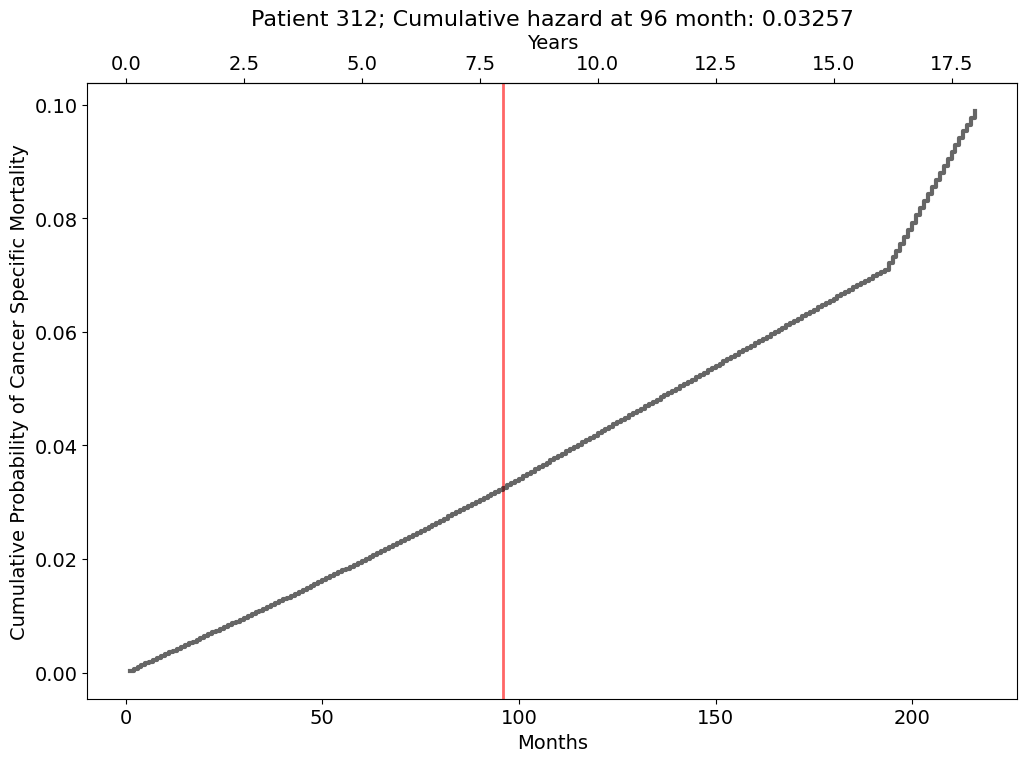

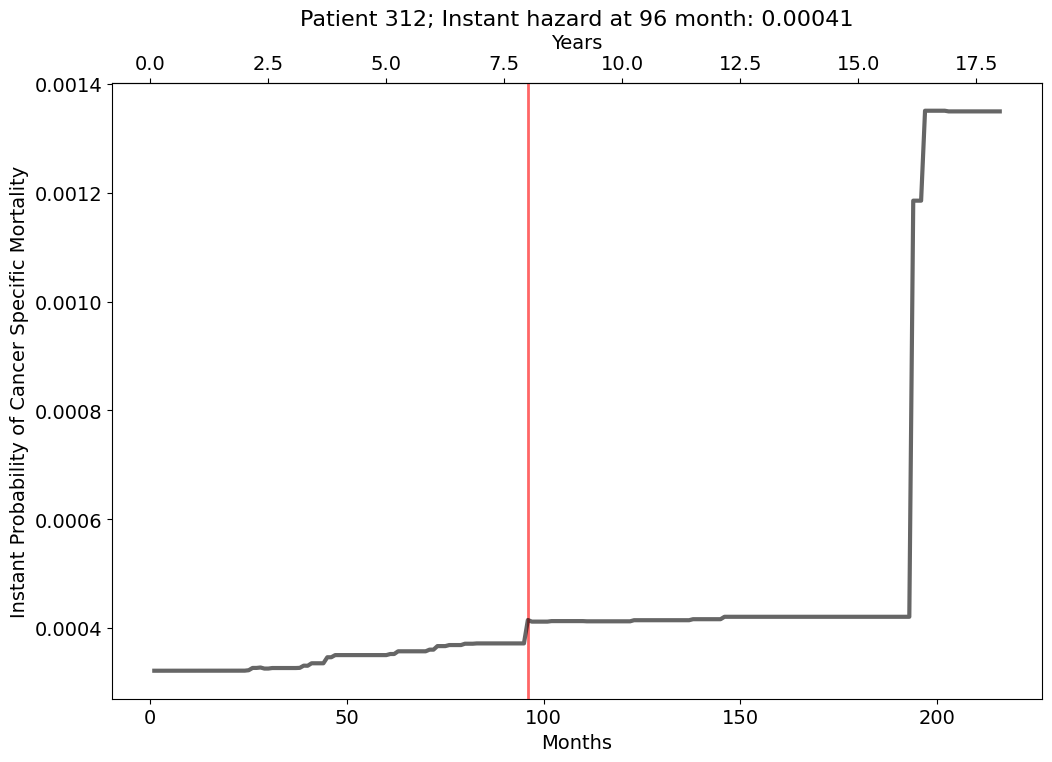

       patient_id   age  survival_months cancer_specific_mortality  \
60696         312  73.0               96                         1   
60791         312  73.0               96                         1   
60875         312  73.0               96                         1   
60911         312  73.0               96                         1   

       survival_time_discrete  cancer_specific_mortality_discrete  \
60696                       1                                 0.0   
60791                      96                                 1.0   
60875                     180                                 NaN   
60911                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
60696                                     0                0.000322   
60791                                     1                0.000415   
60875                                     1                0.000421   
60911              

In [209]:
plot_single_patient(df_train_predicted, patient_id=312, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

print(df_train_predicted[(df_train_predicted.patient_id == 312) & (df_train_predicted.survival_time_discrete.isin([1, 96, 15*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

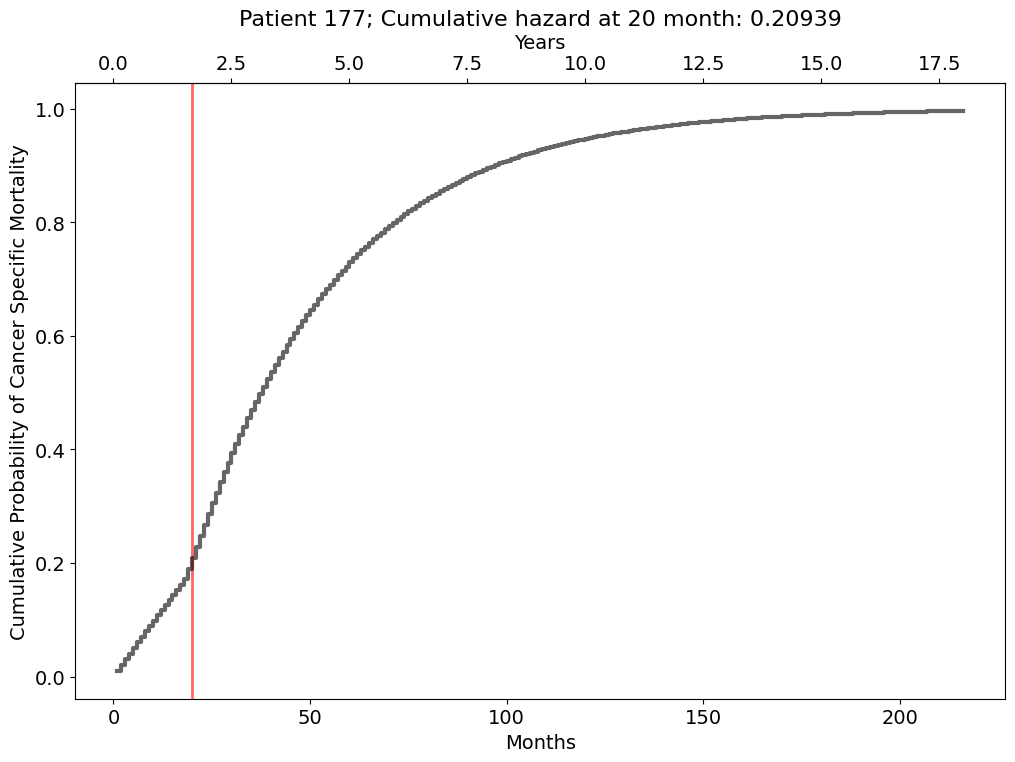

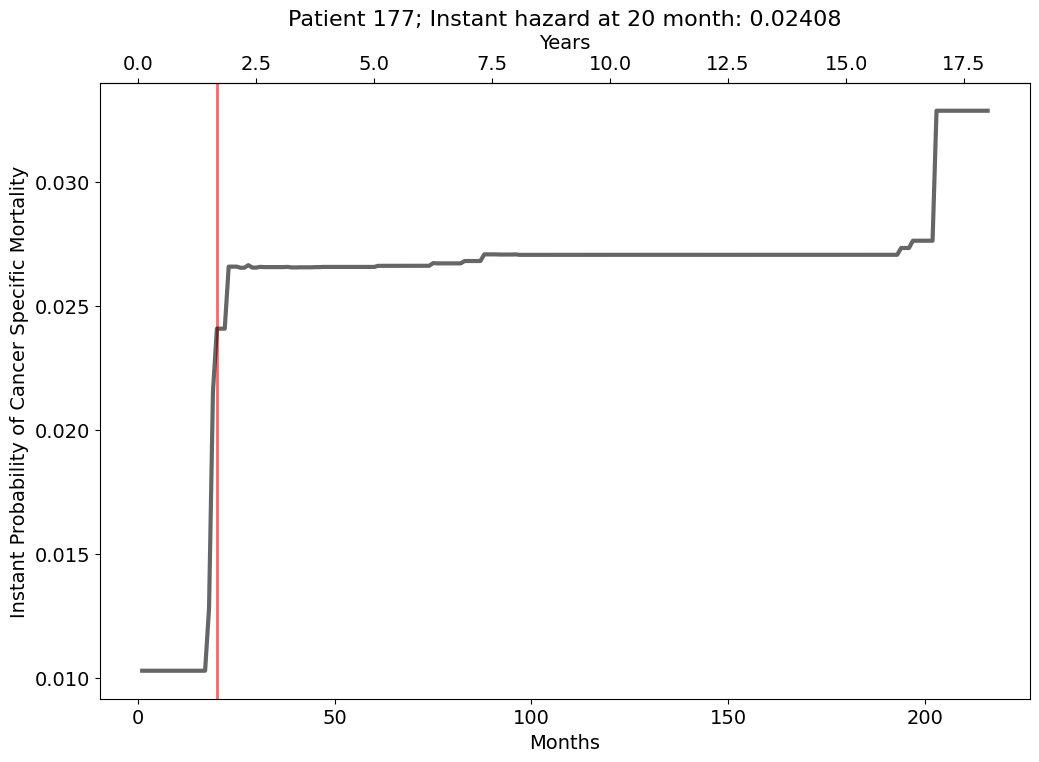

        patient_id   age  survival_months cancer_specific_mortality  \
253800         177  69.0               20                         1   
253819         177  69.0               20                         1   
253859         177  69.0               20                         1   
253919         177  69.0               20                         1   
254015         177  69.0               20                         1   

        survival_time_discrete  cancer_specific_mortality_discrete  \
253800                       1                                 0.0   
253819                      20                                 1.0   
253859                      60                                 NaN   
253919                     120                                 NaN   
254015                     216                                 NaN   

        cancer_specific_mortality_cumulative  mortality_instant_prob  \
253800                                     0                0.010294   
253819  

In [210]:
plot_single_patient(df_train_predicted, patient_id=177, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

print(df_train_predicted[(df_train_predicted.patient_id == 177) & (df_train_predicted.survival_time_discrete.isin([1, 20, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

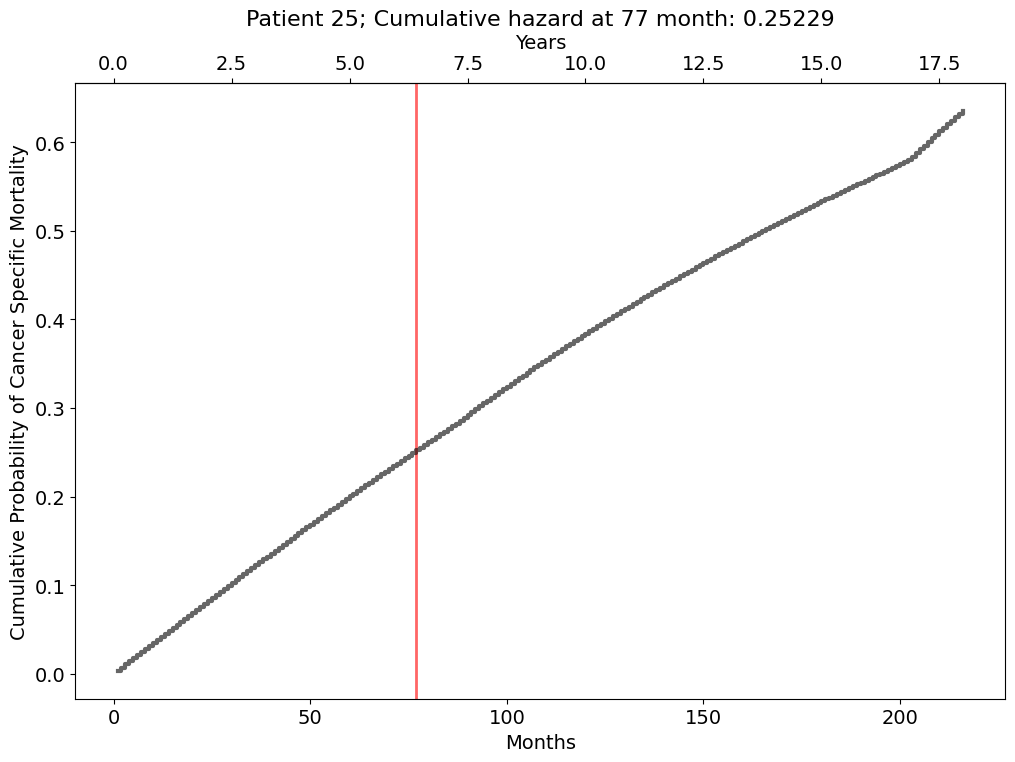

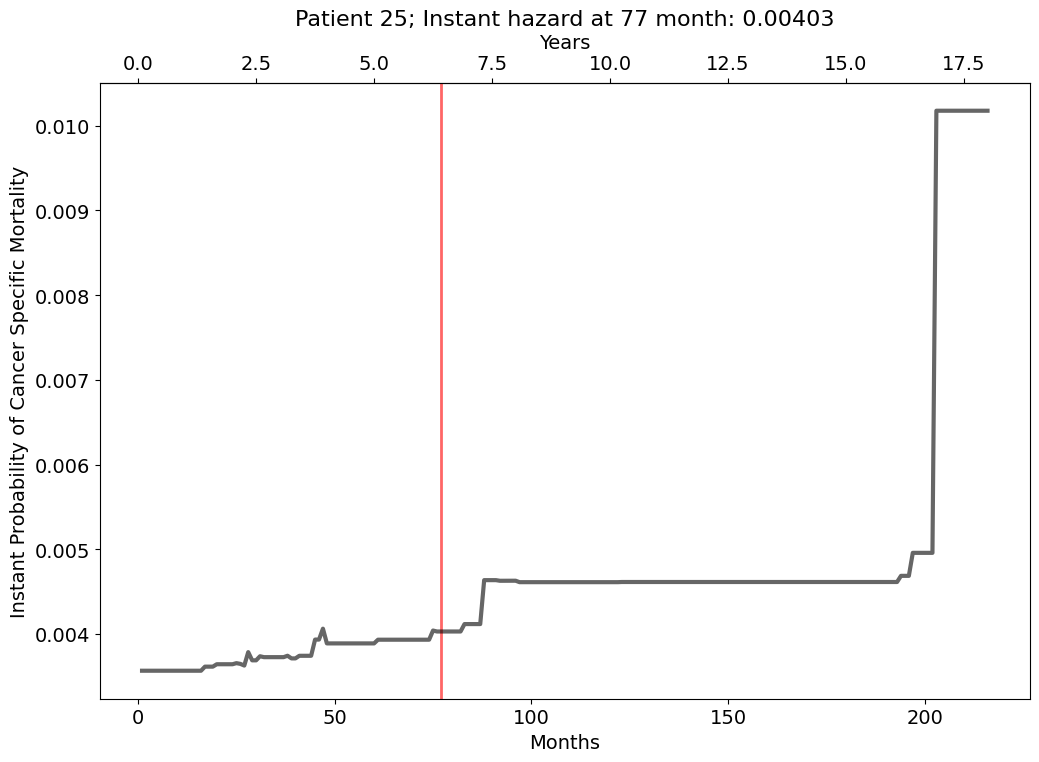

In [211]:
plot_single_patient(df_test_predicted, patient_id=25, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

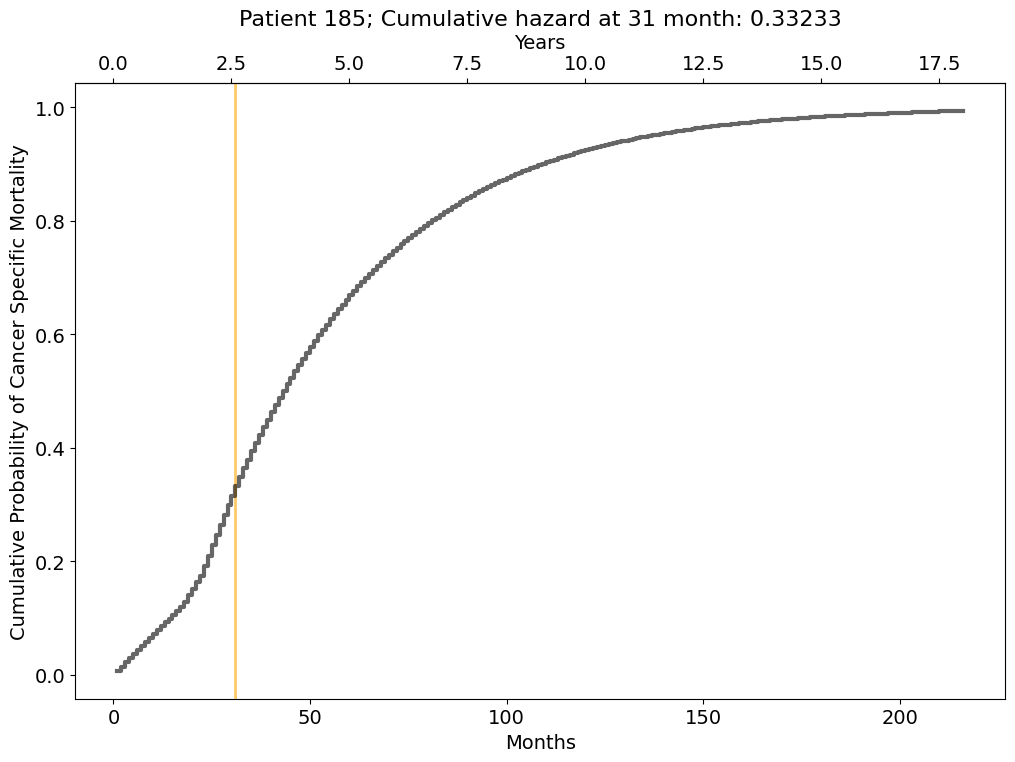

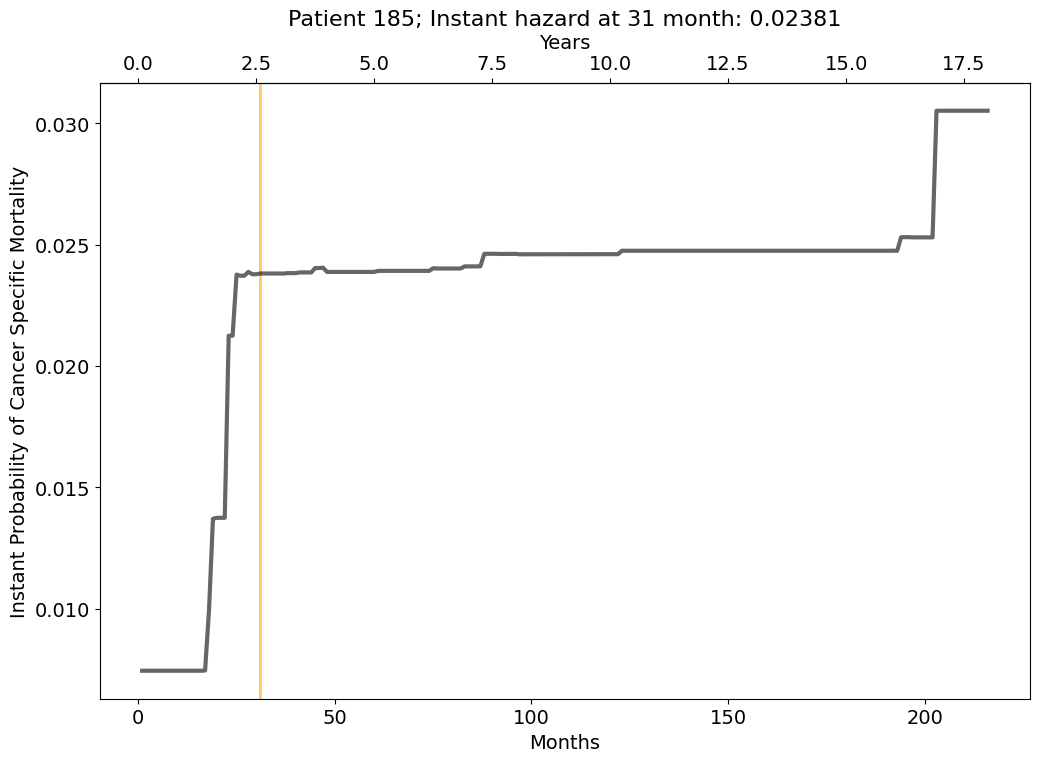

       patient_id   age  survival_months cancer_specific_mortality  \
11664         185  72.0               31                         0   
11694         185  72.0               31                         0   
11723         185  72.0               31                         0   
11783         185  72.0               31                         0   
11879         185  72.0               31                         0   

       survival_time_discrete  cancer_specific_mortality_discrete  \
11664                       1                                 0.0   
11694                      31                                 0.0   
11723                      60                                 NaN   
11783                     120                                 NaN   
11879                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
11664                                     0                0.007452   
11694                 

In [212]:
plot_single_patient(df_test_predicted, patient_id=185, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

print(df_test_predicted[(df_test_predicted.patient_id == 185) & (df_test_predicted.survival_time_discrete.isin([1, 31, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

In [213]:
# neural network optimal
# Load optimal model

model_name = 'MLPClassifier'
max_time = 216
experiment_name = 'Experiment 004'

model, auc_stats = read_experiment(model_name=model_name, target_column='cancer_specific_mortality',
                                   max_time=max_time, is_homogenous_dataset=False,
                                   experiment_name=experiment_name)

In [214]:
df_train = data_train.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1)
df_test = data_test.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1) 

# Test on training data
df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                    target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

# Test on testing data
df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

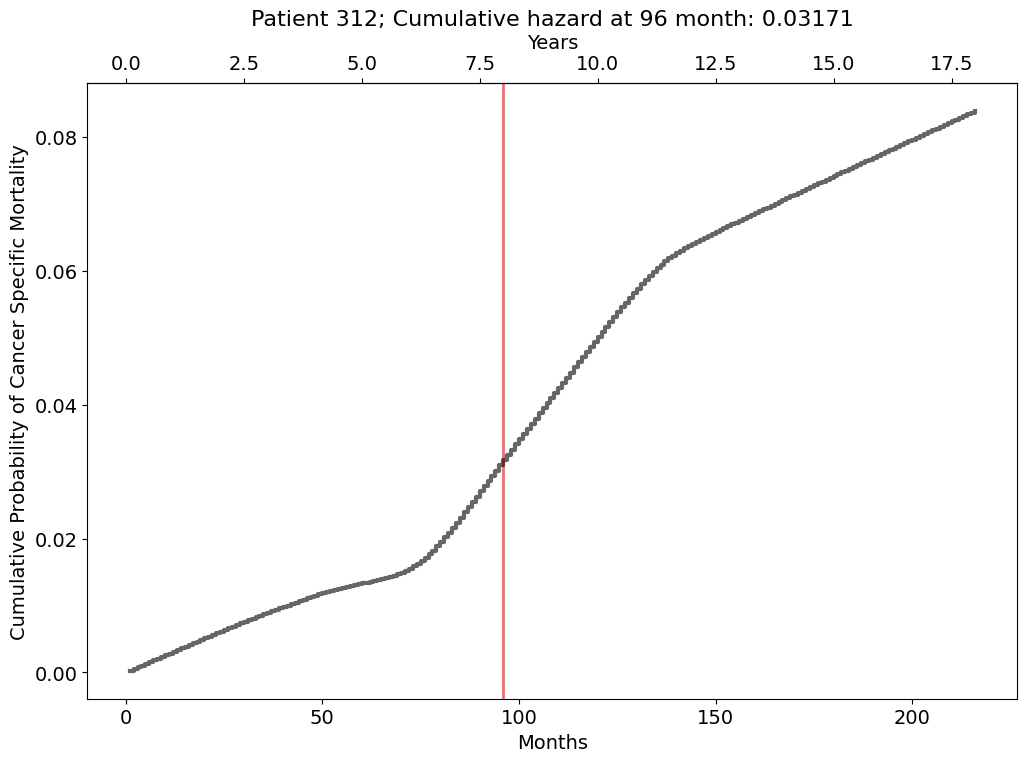

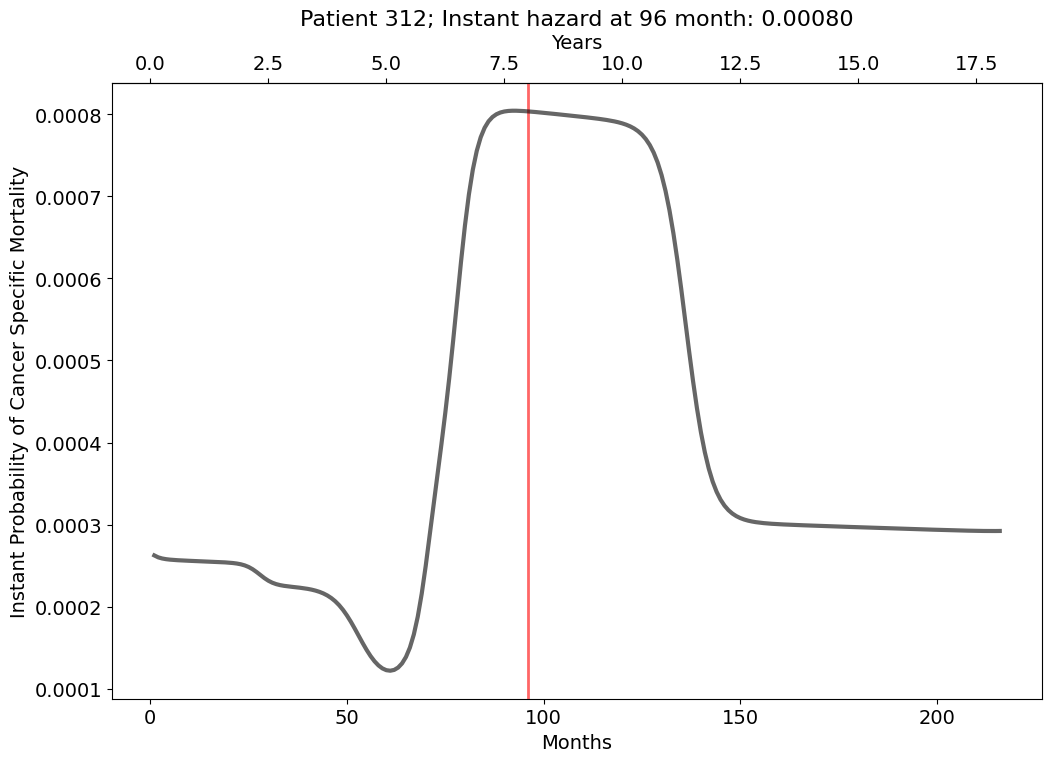

In [215]:
plot_single_patient(df_train_predicted, patient_id=312, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

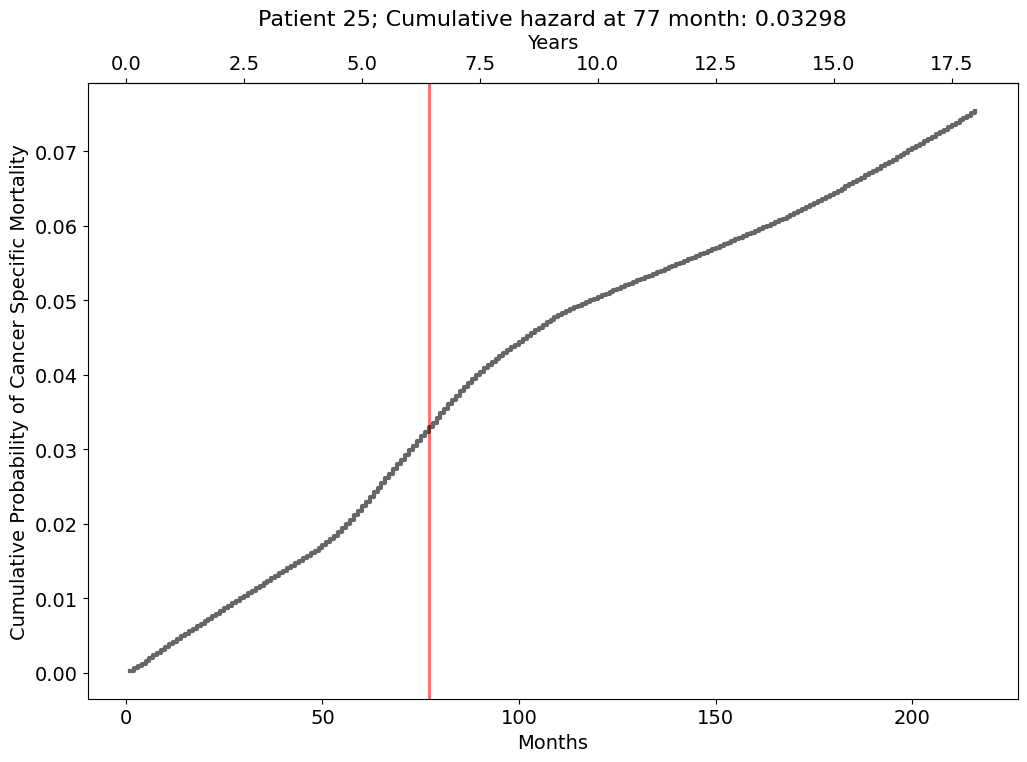

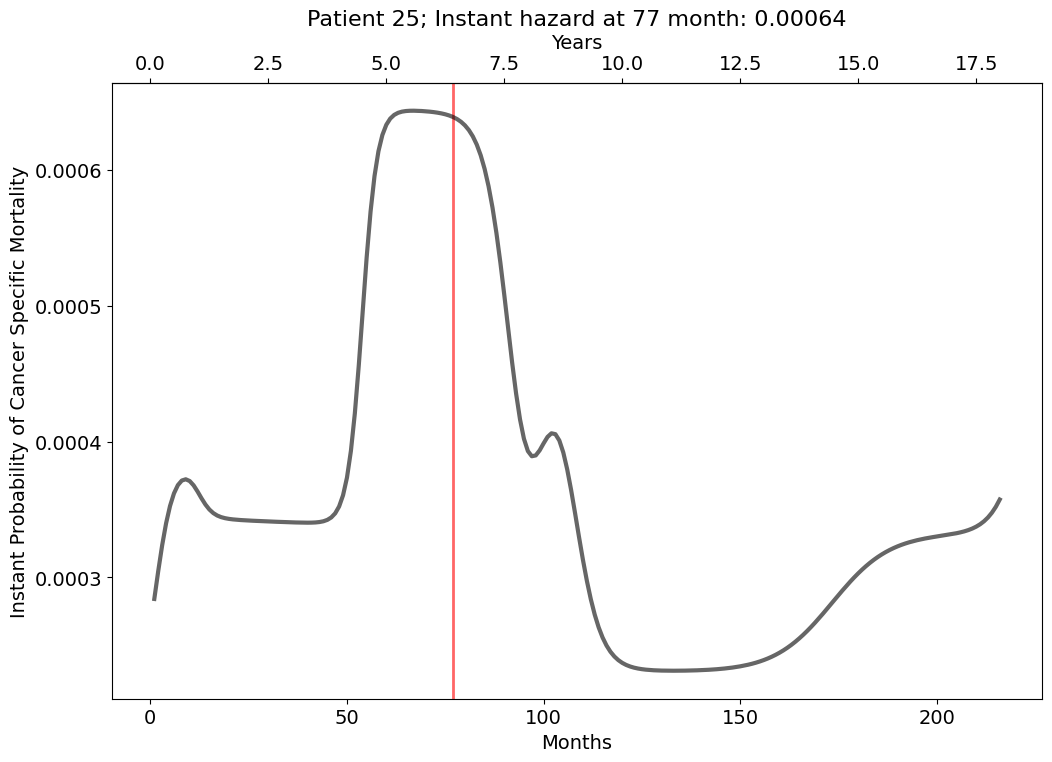

In [216]:
plot_single_patient(df_test_predicted, patient_id=25, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

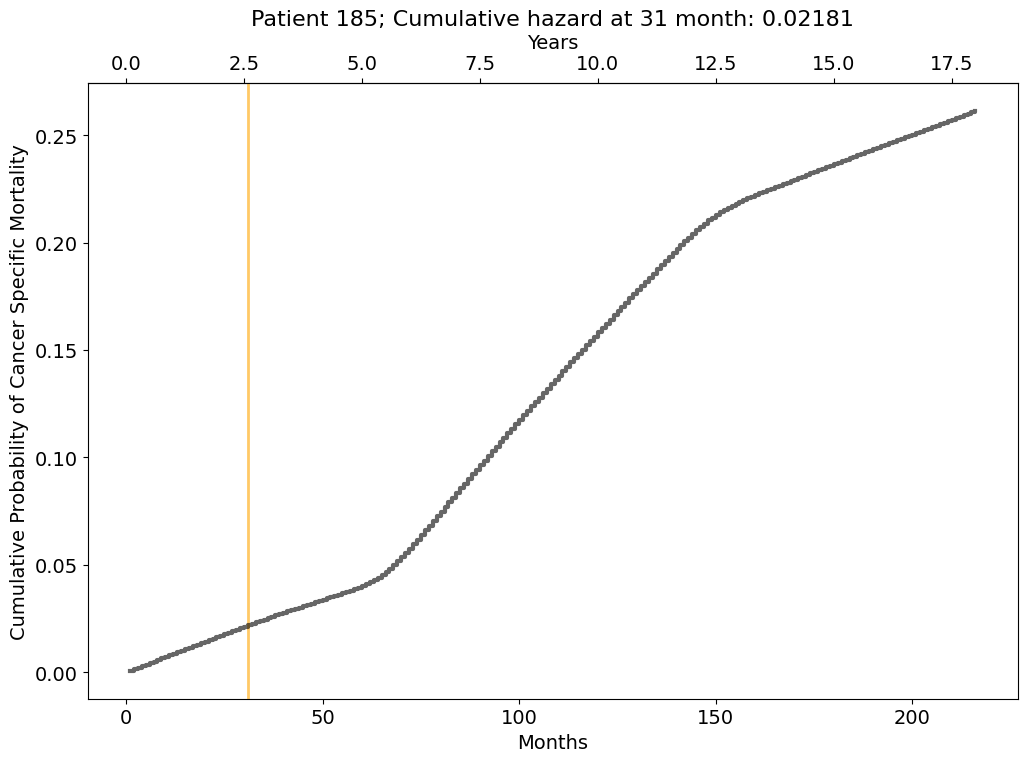

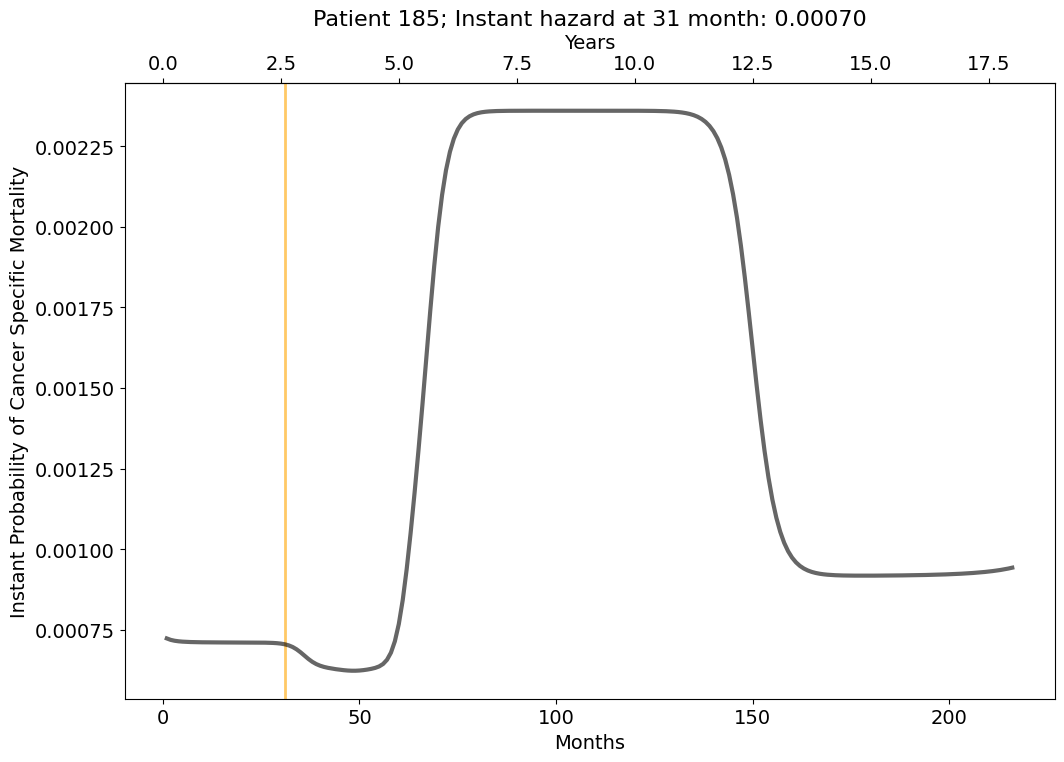

In [217]:
plot_single_patient(df_test_predicted, patient_id=185, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

In [218]:
# xgboost optimal
# Load optimal model

model_name = 'XGBClassifier'
max_time = 216
experiment_name = 'defaultExperiment'

model, auc_stats = read_experiment(model_name=model_name, target_column='cancer_specific_mortality',
                                   max_time=max_time, is_homogenous_dataset=False,
                                   experiment_name=experiment_name)

In [219]:
df_train = data_train.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1)
df_test = data_test.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1) 

# Test on training data
df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                    target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

# Test on testing data
df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

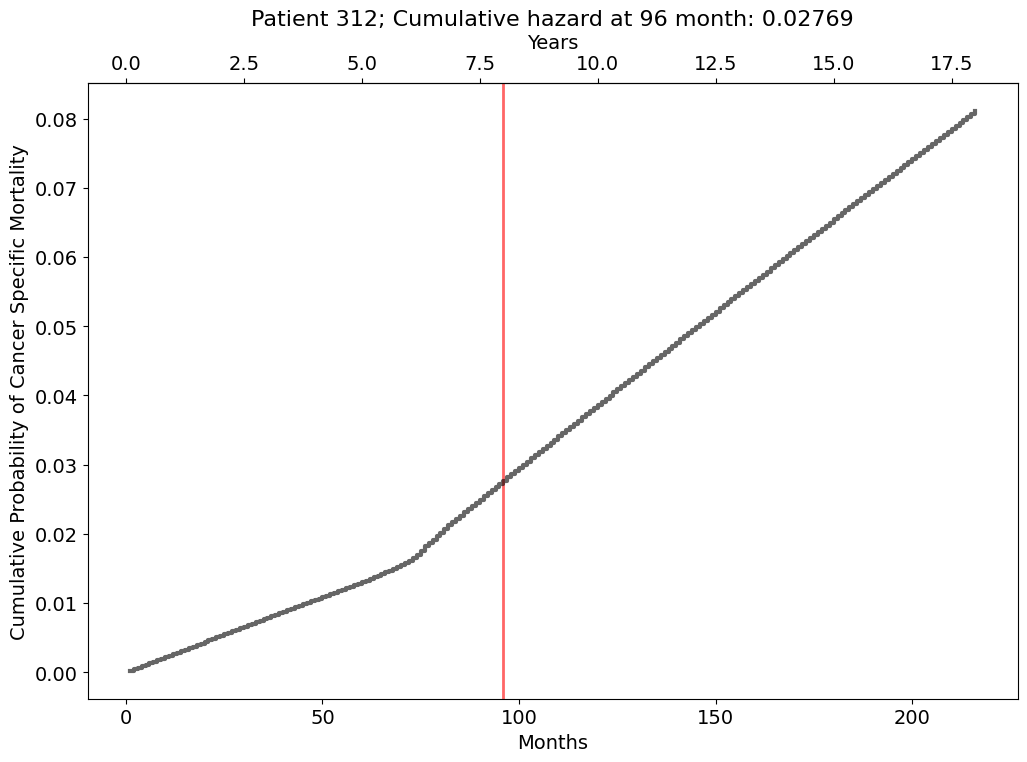

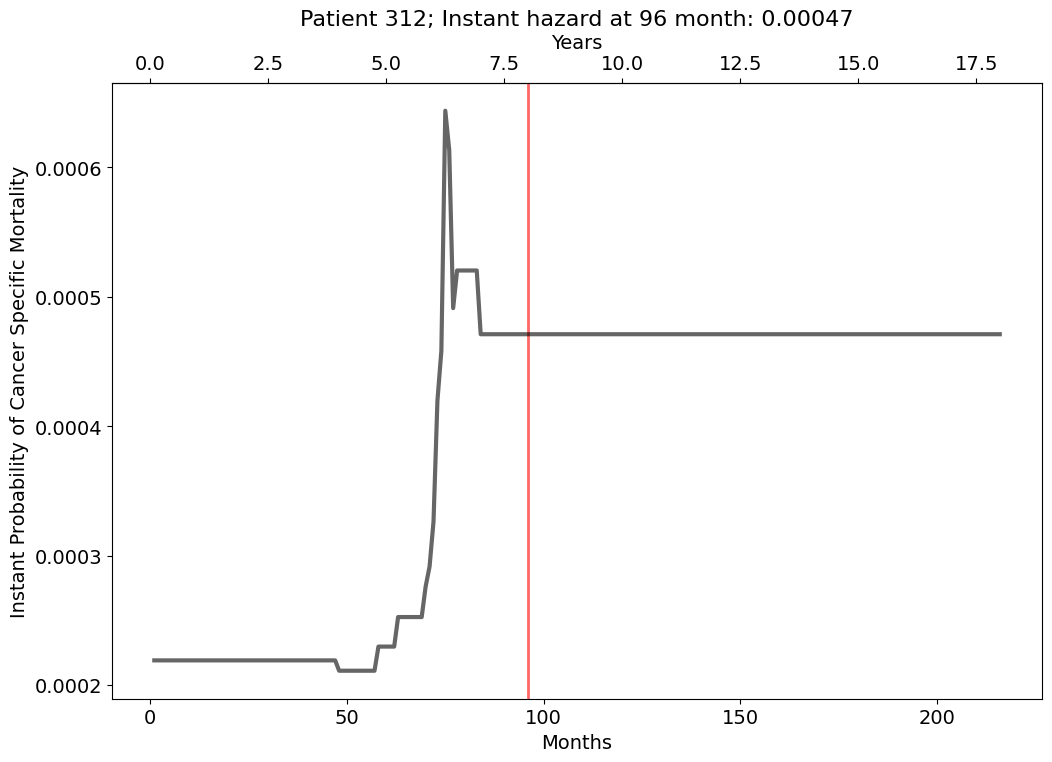

In [220]:
plot_single_patient(df_train_predicted, patient_id=312, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

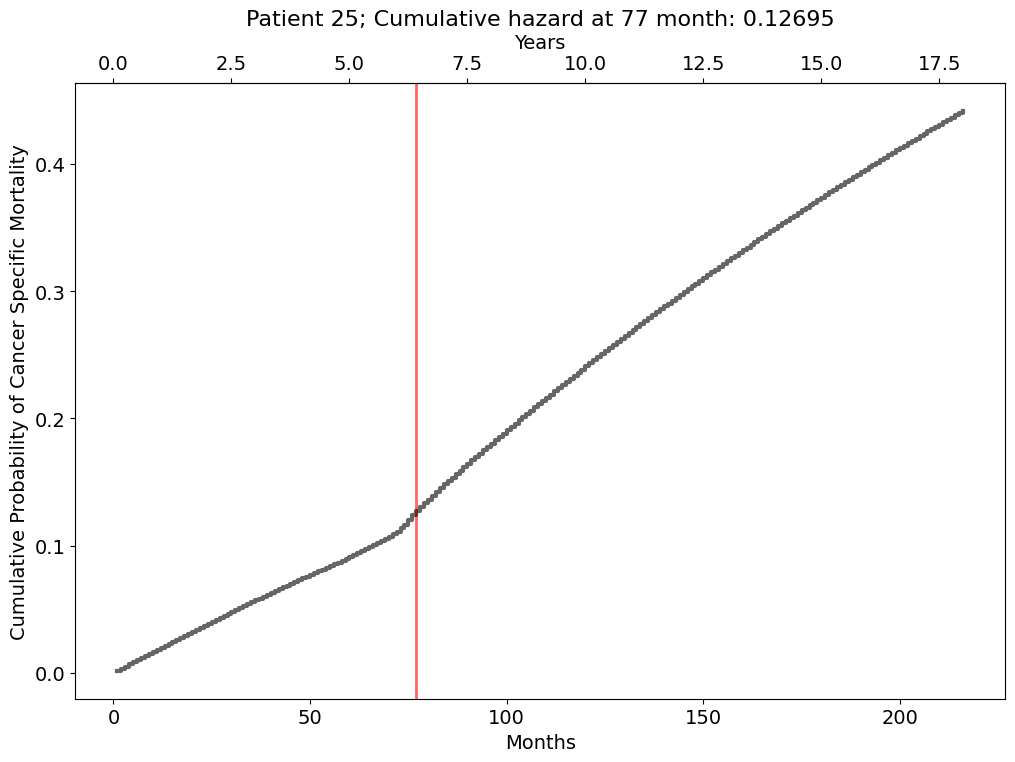

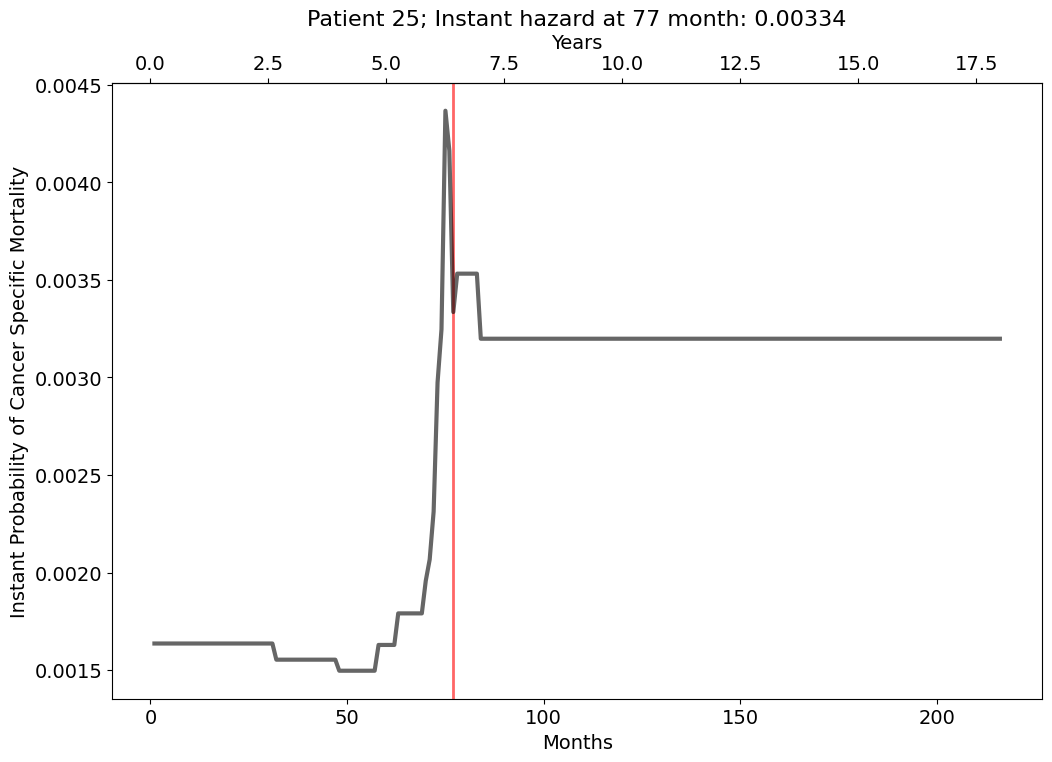

In [221]:
plot_single_patient(df_test_predicted, patient_id=25, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

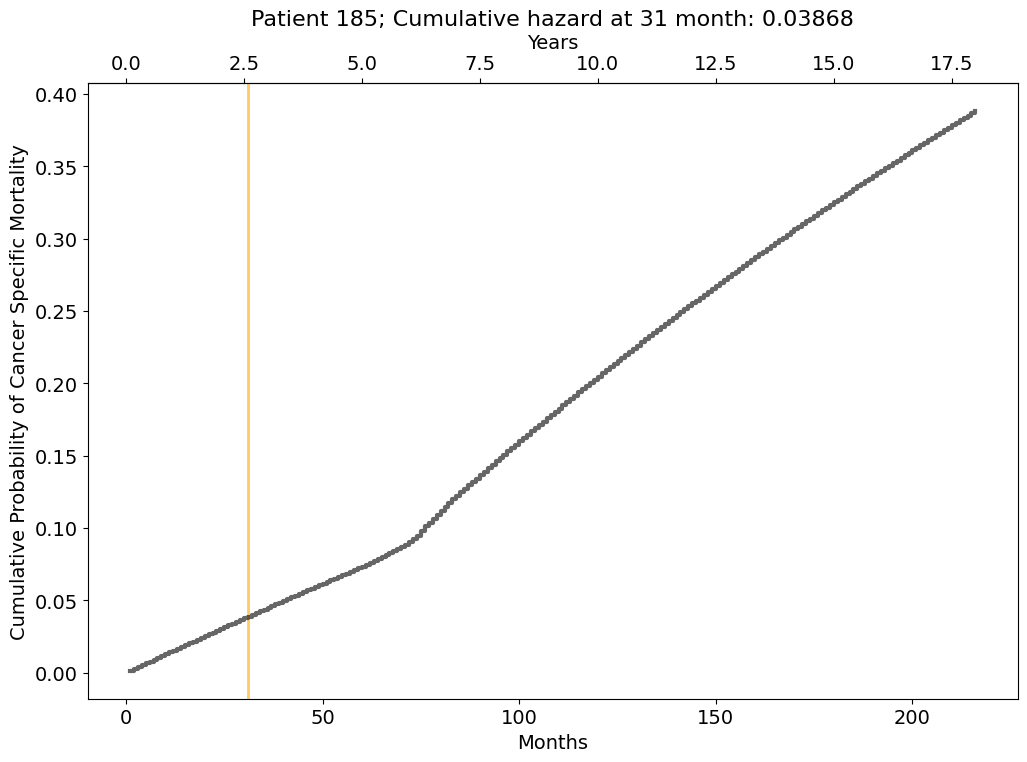

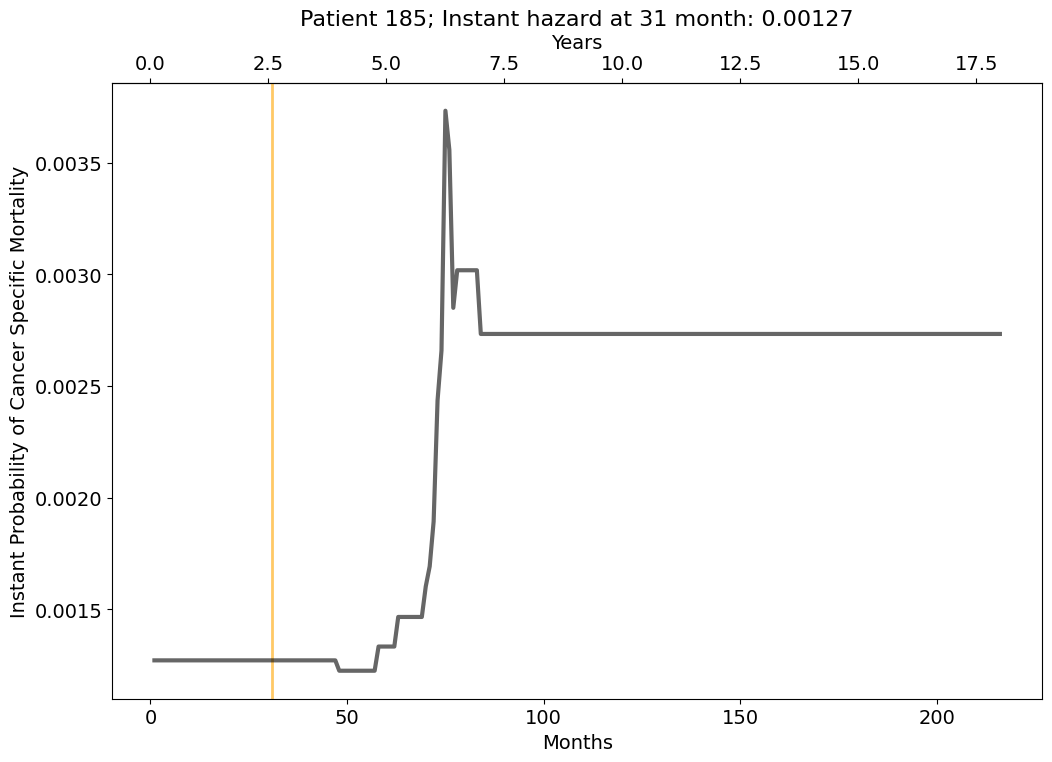

In [222]:
plot_single_patient(df_test_predicted, patient_id=185, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

In [223]:
# logistic regression
# Load optimal model

model_name = 'LogisticRegression'
max_time = 216
experiment_name = 'defaultExperiment'

model, auc_stats = read_experiment(model_name=model_name, target_column='cancer_specific_mortality',
                                   max_time=max_time, is_homogenous_dataset=False,
                                   experiment_name=experiment_name)

In [224]:
df_train = data_train.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1)
df_test = data_test.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1) 

# Test on training data
df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                    target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

# Test on testing data
df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

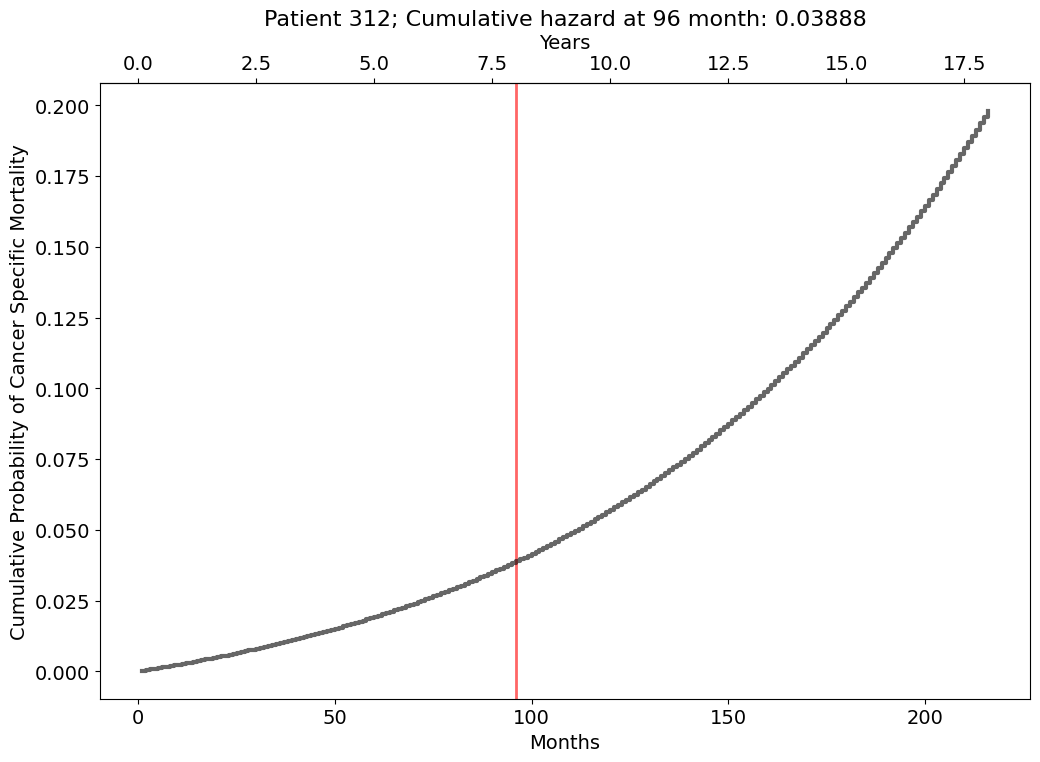

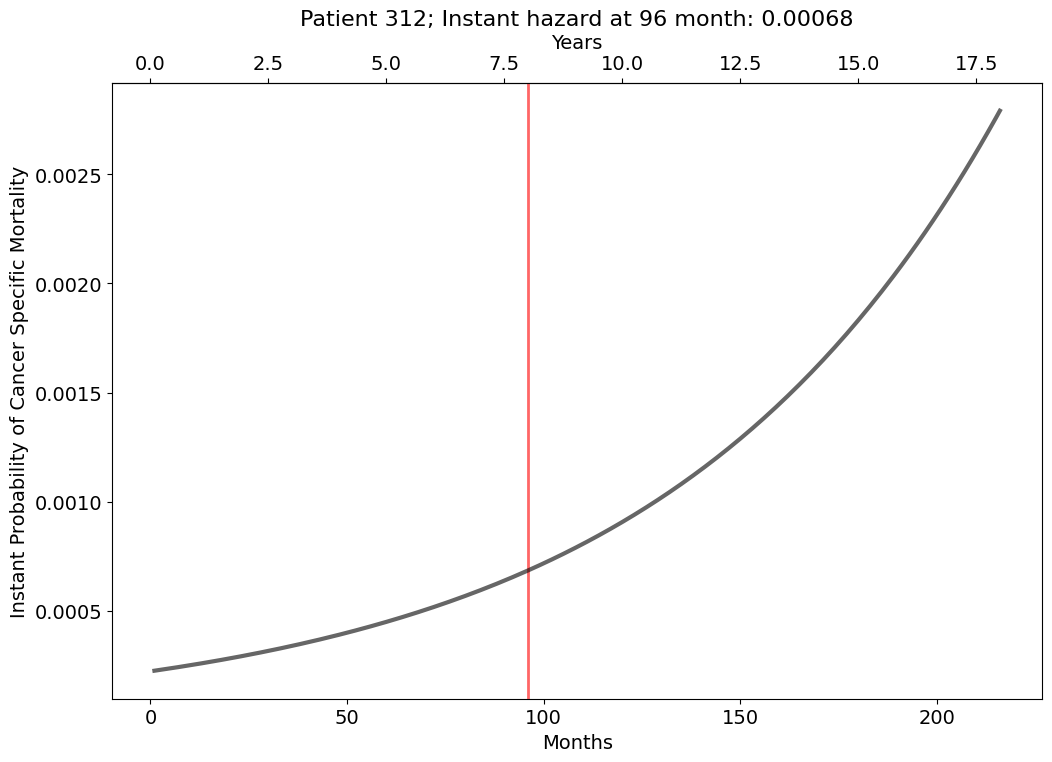

In [225]:
plot_single_patient(df_train_predicted, patient_id=312, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

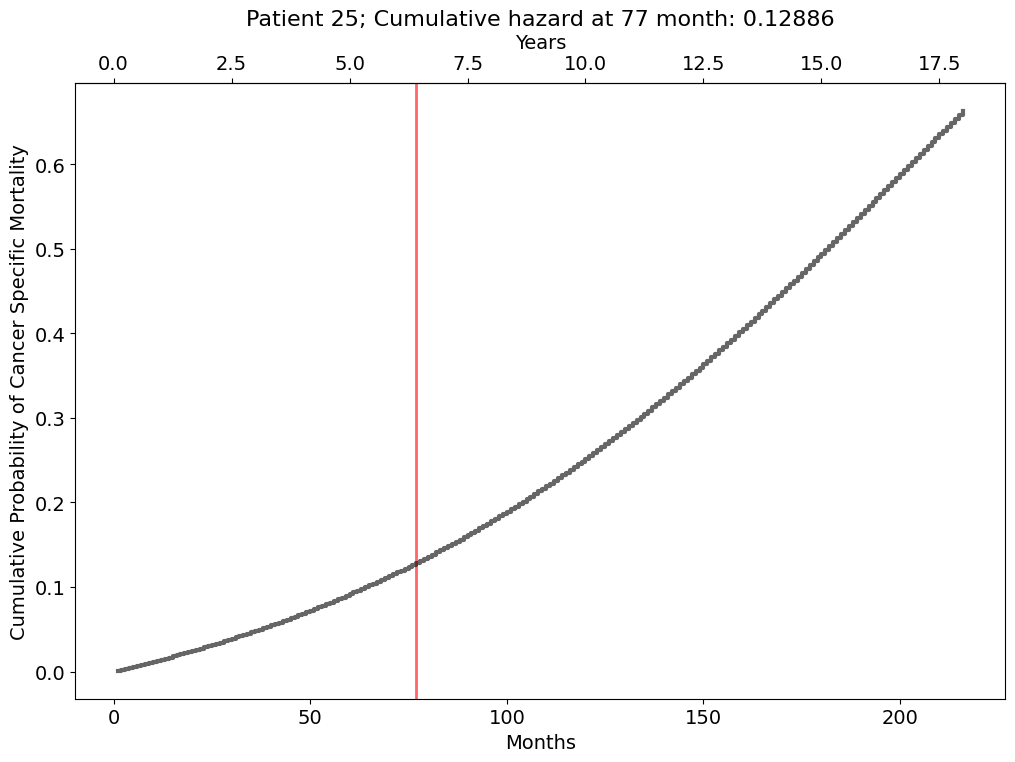

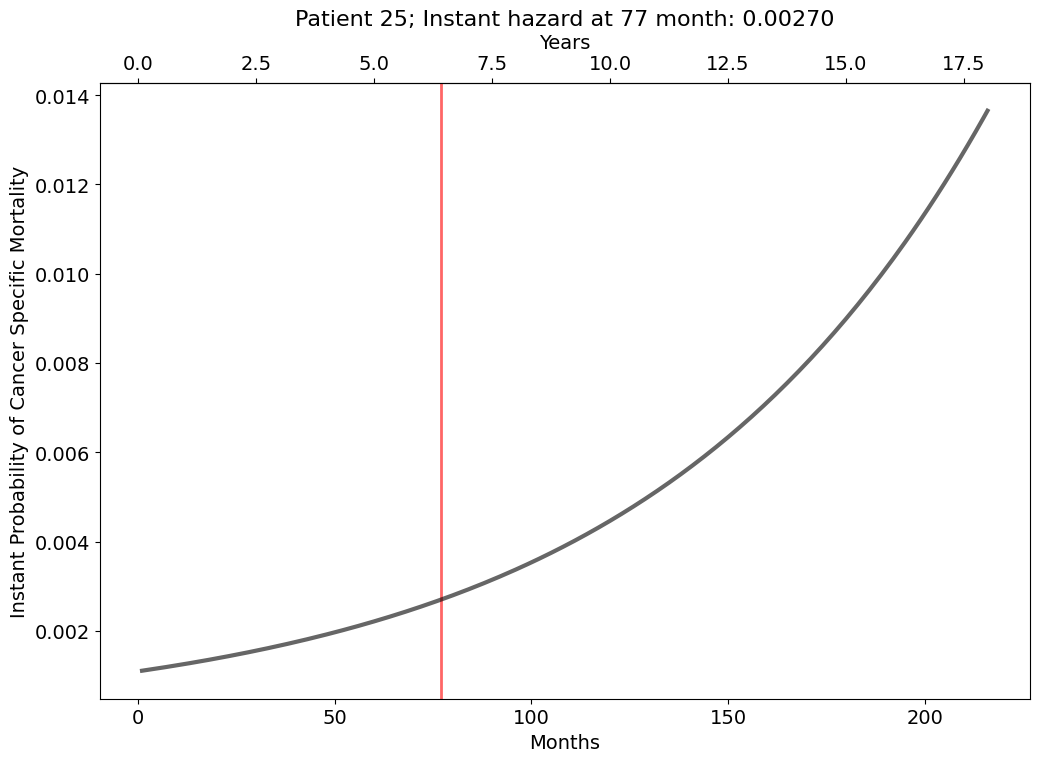

In [226]:
plot_single_patient(df_test_predicted, patient_id=25, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

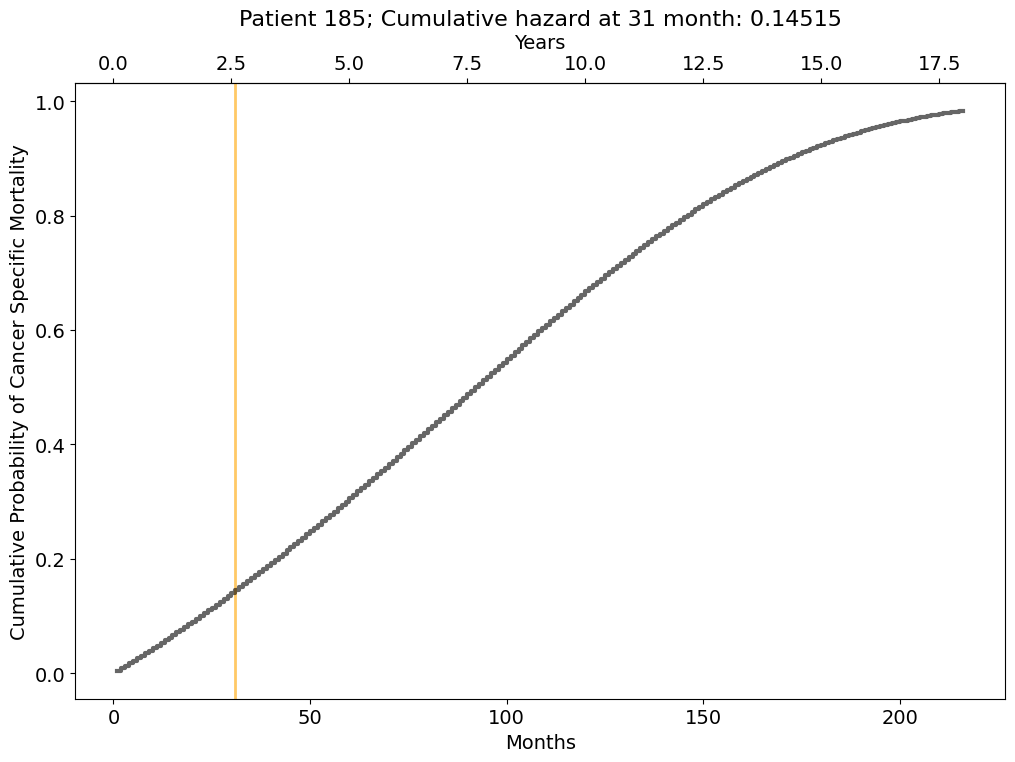

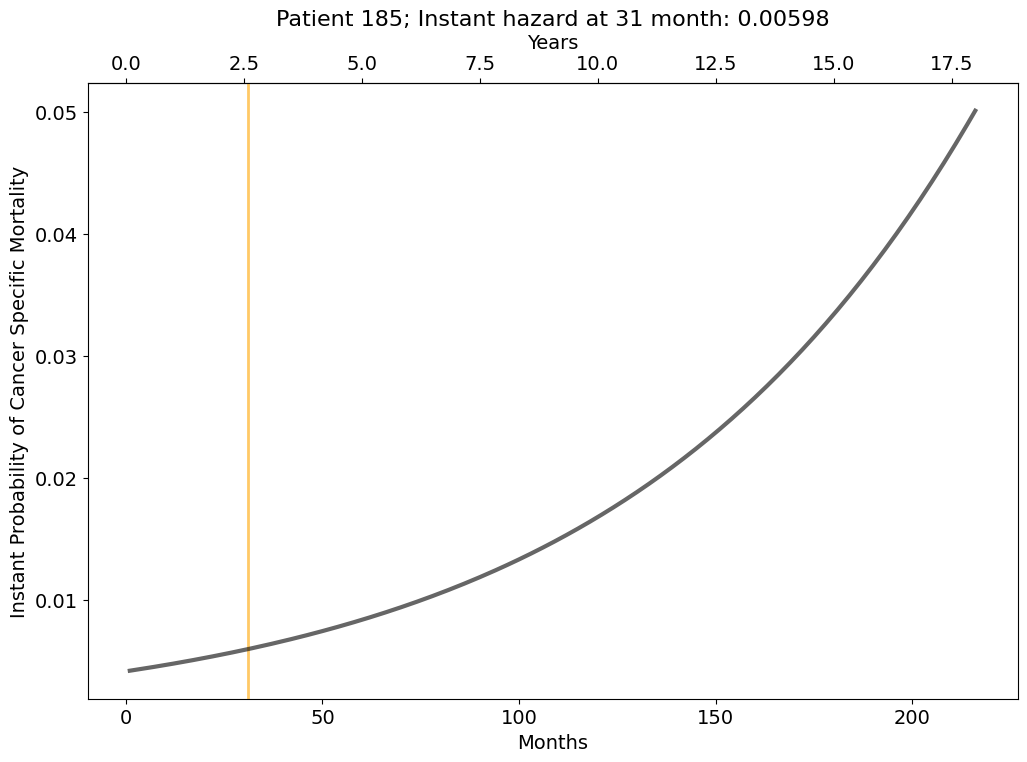

In [227]:
plot_single_patient(df_test_predicted, patient_id=185, target_column=target_column, 
                    target_title='Cancer Specific Mortality', fix_axis=False, model_name=model_name,
                    max_time=max_time, experiment_name=experiment_name)

In [228]:
def plot_single_patient_compare_models(df_lr, df_rf, df_xgb, df_nn, patient_id, target_column, fix_axis=True):
    
    if patient_id not in df_lr['patient_id'].values:
        print(f'Patient {patient_id} is not in the dataset.')

    # Subset of data for the given patient
    person_rf = df_rf[df_rf['patient_id'] == patient_id]
    person_nn = df_nn[df_nn['patient_id'] == patient_id]
    person_xgb = df_xgb[df_xgb['patient_id'] == patient_id]
    person_lr = df_lr[df_lr['patient_id'] == patient_id]

    # Get the column indexes of required columns
    mortality_column_index = person_rf.columns.get_loc(target_column)
    survival_column_index = person_rf.columns.get_loc('survival_months')
    max_time_value = person_rf.survival_time_discrete.max()

    # Plot cumulative mortality of the given patient
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8, forward=True)

    ax.plot(person_rf['survival_time_discrete'],person_rf['cumulative_hazard'],
        alpha=0.6,color='k',drawstyle='steps-post', linewidth=3)

    ax.plot(person_nn['survival_time_discrete'],person_nn['cumulative_hazard'],
        alpha=0.6,color='b',drawstyle='steps-post', linewidth=3)

    ax.plot(person_xgb['survival_time_discrete'],person_xgb['cumulative_hazard'],
        alpha=0.6,color='g',drawstyle='steps-post', linewidth=3)

    ax.plot(person_lr['survival_time_discrete'],person_lr['cumulative_hazard'],
        alpha=0.6,color='y',drawstyle='steps-post', linewidth=3)

    ax.legend(['Random forest', 'Neural network', 'XGBoost', 'Logistic regression'])

    # Add line when the patient actually died
    if person_rf.iloc[0,mortality_column_index] == '1' and person_rf.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person_rf.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                    color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person_rf.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                    color='orange',linewidth=2, zorder=1)

    ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
    ax2.set_xlabel("Years")

    ax.set_xlabel('Months')
    ax.set_ylabel('Cumulative Probability of Cancer Specific Mortality')
    if fix_axis:
        ax.set_ylim([0, 1])
        
    plt.suptitle(f'Patient {person_rf.patient_id.iloc[0]:.0f}')
    plt.savefig(f'eda/single-experiment/cumulative_person_{person_rf.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()
    

    # Plot instant mortality of the given patient
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8, forward=True)
    
    ax.plot(person_rf['survival_time_discrete'],person_rf['mortality_instant_prob'],
        alpha=0.6,color='k', linewidth=3)
    
    ax.plot(person_nn['survival_time_discrete'],person_nn['mortality_instant_prob'],
        alpha=0.6,color='b', linewidth=3)
    
    ax.plot(person_xgb['survival_time_discrete'],person_xgb['mortality_instant_prob'],
        alpha=0.6,color='g', linewidth=3)
    
    ax.plot(person_lr['survival_time_discrete'],person_lr['mortality_instant_prob'],
        alpha=0.6,color='y', linewidth=3)
    
    ax.legend(['Random forest', 'Neural network', 'XGBoost', 'Logistic regression'])
    
    # Add line when the patient actually died
    if person_rf.iloc[0,mortality_column_index] == '1' and person_rf.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person_rf.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person_rf.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='orange',linewidth=2, zorder=1)
    
    ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
    ax2.set_xlabel("Years")
    
    ax.set_xlabel('Months')
    ax.set_ylabel('Instant Probability of Cancer Specific Mortality')
    if fix_axis:
        ax.set_ylim([0, 1])
        
    plt.suptitle(f'Patient {person_rf.patient_id.iloc[0]:.0f}')
    plt.savefig(f'eda/single-experiment/instant_person_{person_rf.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()

In [229]:
# comparison of different models on single patient

rf_model, rf_auc_stats = read_experiment(model_name='RandomForestClassifier', target_column='cancer_specific_mortality',
                                   max_time=216, is_homogenous_dataset=False,
                                   experiment_name='defaultExperiment')

nn_model, nn_auc_stats = read_experiment(model_name='MLPClassifier', target_column='cancer_specific_mortality',
                                   max_time=216, is_homogenous_dataset=False,
                                   experiment_name='Experiment 004')

xgb_model, xgb_auc_stats = read_experiment(model_name='XGBClassifier', target_column='cancer_specific_mortality',
                                   max_time=216, is_homogenous_dataset=False,
                                   experiment_name='defaultExperiment')

lr_model, lr_auc_stats = read_experiment(model_name='LogisticRegression', target_column='cancer_specific_mortality',
                                   max_time=216, is_homogenous_dataset=False,
                                   experiment_name='defaultExperiment')

In [230]:
df_test = data_test.drop(['bcr', 'mts', 'death_from_other_causes'], axis=1) 

# Test on testing data
rf_df_test_predicted = add_predict_probabilities(df_test, model=rf_model, max_time=216, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

nn_df_test_predicted = add_predict_probabilities(df_test, model=nn_model, max_time=216, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

xgb_df_test_predicted = add_predict_probabilities(df_test, model=xgb_model, max_time=216, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

lr_df_test_predicted = add_predict_probabilities(df_test, model=lr_model, max_time=216, 
                                                target_column=target_column, time=time,
                                                is_homogenous_dataset=False)

In [231]:
print(rf_df_test_predicted[(rf_df_test_predicted.patient_id == 25) & (rf_df_test_predicted.survival_time_discrete.isin([1, 5*12, 77, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
61344          25  67.0               77                         1   
61403          25  67.0               77                         1   
61420          25  67.0               77                         1   
61463          25  67.0               77                         1   
61559          25  67.0               77                         1   

       survival_time_discrete  cancer_specific_mortality_discrete  \
61344                       1                                 0.0   
61403                      60                                 0.0   
61420                      77                                 1.0   
61463                     120                                 NaN   
61559                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
61344                                     0                0.003568   
61403                 

In [232]:
print(nn_df_test_predicted[(nn_df_test_predicted.patient_id == 25) & (nn_df_test_predicted.survival_time_discrete.isin([1, 5*12, 77, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
61344          25  67.0               77                         1   
61403          25  67.0               77                         1   
61420          25  67.0               77                         1   
61463          25  67.0               77                         1   
61559          25  67.0               77                         1   

       survival_time_discrete  cancer_specific_mortality_discrete  \
61344                       1                                 0.0   
61403                      60                                 0.0   
61420                      77                                 1.0   
61463                     120                                 NaN   
61559                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
61344                                     0                0.000284   
61403                 

In [233]:
print(xgb_df_test_predicted[(xgb_df_test_predicted.patient_id == 25) & (xgb_df_test_predicted.survival_time_discrete.isin([1, 5*12, 77, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
61344          25  67.0               77                         1   
61403          25  67.0               77                         1   
61420          25  67.0               77                         1   
61463          25  67.0               77                         1   
61559          25  67.0               77                         1   

       survival_time_discrete  cancer_specific_mortality_discrete  \
61344                       1                                 0.0   
61403                      60                                 0.0   
61420                      77                                 1.0   
61463                     120                                 NaN   
61559                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
61344                                     0                0.001636   
61403                 

In [234]:
print(lr_df_test_predicted[(lr_df_test_predicted.patient_id == 25) & (lr_df_test_predicted.survival_time_discrete.isin([1, 5*12, 77, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
61344          25  67.0               77                         1   
61403          25  67.0               77                         1   
61420          25  67.0               77                         1   
61463          25  67.0               77                         1   
61559          25  67.0               77                         1   

       survival_time_discrete  cancer_specific_mortality_discrete  \
61344                       1                                 0.0   
61403                      60                                 0.0   
61420                      77                                 1.0   
61463                     120                                 NaN   
61559                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
61344                                     0                0.001109   
61403                 

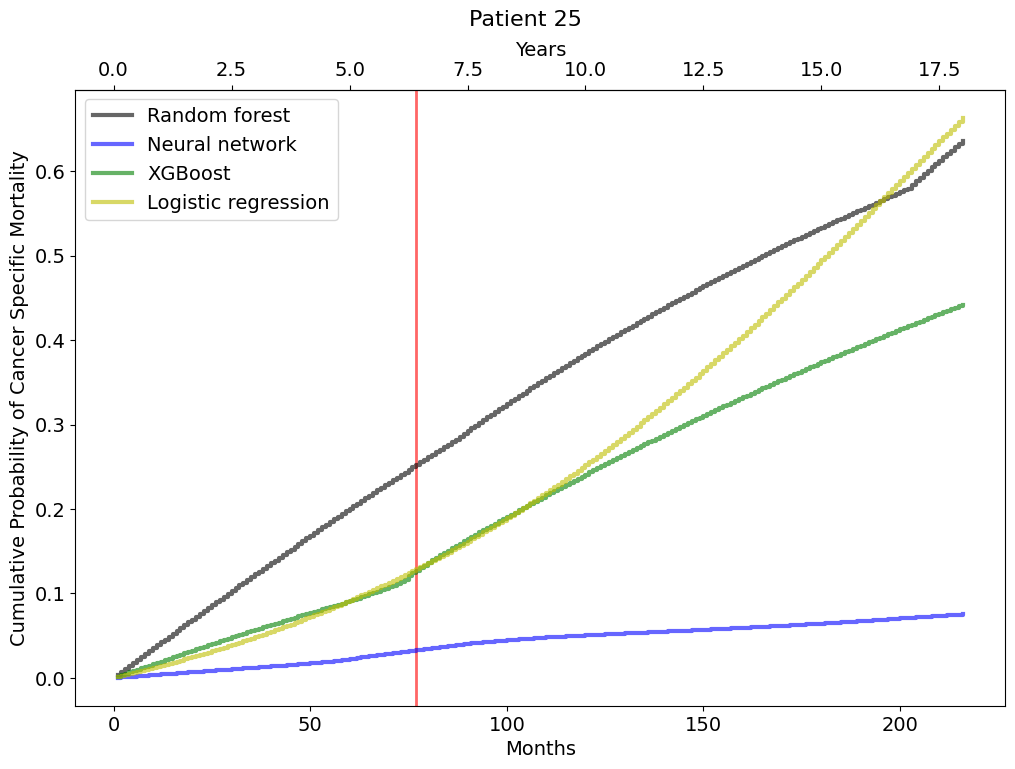

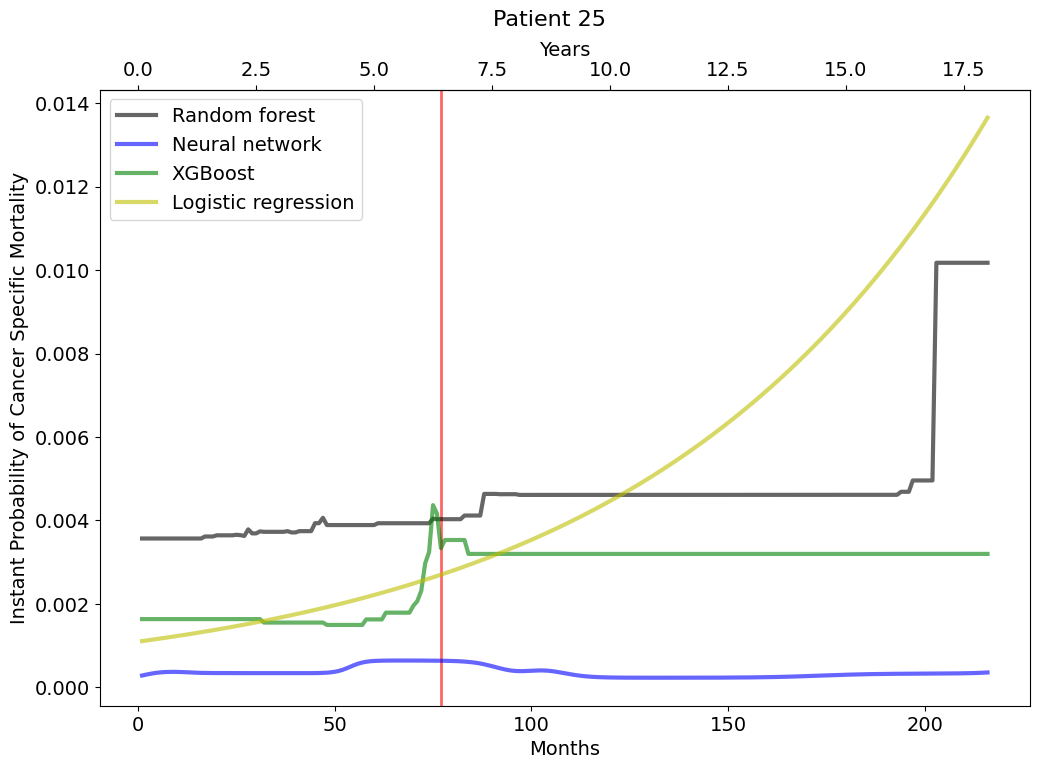

In [235]:
plot_single_patient_compare_models(df_lr=lr_df_test_predicted, df_rf=rf_df_test_predicted, df_xgb=xgb_df_test_predicted, df_nn=nn_df_test_predicted,
                                   patient_id=25, target_column='cancer_specific_mortality', fix_axis=False)

In [236]:
print(rf_df_test_predicted[(rf_df_test_predicted.patient_id == 185) & (rf_df_test_predicted.survival_time_discrete.isin([1, 31, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
11664         185  72.0               31                         0   
11694         185  72.0               31                         0   
11723         185  72.0               31                         0   
11783         185  72.0               31                         0   
11879         185  72.0               31                         0   

       survival_time_discrete  cancer_specific_mortality_discrete  \
11664                       1                                 0.0   
11694                      31                                 0.0   
11723                      60                                 NaN   
11783                     120                                 NaN   
11879                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
11664                                     0                0.007452   
11694                 

In [237]:
print(nn_df_test_predicted[(nn_df_test_predicted.patient_id == 185) & (nn_df_test_predicted.survival_time_discrete.isin([1, 31, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
11664         185  72.0               31                         0   
11694         185  72.0               31                         0   
11723         185  72.0               31                         0   
11783         185  72.0               31                         0   
11879         185  72.0               31                         0   

       survival_time_discrete  cancer_specific_mortality_discrete  \
11664                       1                                 0.0   
11694                      31                                 0.0   
11723                      60                                 NaN   
11783                     120                                 NaN   
11879                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
11664                                     0                0.000723   
11694                 

In [238]:
print(xgb_df_test_predicted[(xgb_df_test_predicted.patient_id == 185) & (xgb_df_test_predicted.survival_time_discrete.isin([1, 31, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
11664         185  72.0               31                         0   
11694         185  72.0               31                         0   
11723         185  72.0               31                         0   
11783         185  72.0               31                         0   
11879         185  72.0               31                         0   

       survival_time_discrete  cancer_specific_mortality_discrete  \
11664                       1                                 0.0   
11694                      31                                 0.0   
11723                      60                                 NaN   
11783                     120                                 NaN   
11879                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
11664                                     0                0.001272   
11694                 

In [239]:
print(lr_df_test_predicted[(lr_df_test_predicted.patient_id == 185) & (lr_df_test_predicted.survival_time_discrete.isin([1, 31, 5*12, 10*12, 216]))][['patient_id', 'age', 'survival_months', 'cancer_specific_mortality', 
                                                                                                               'survival_time_discrete', 'cancer_specific_mortality_discrete', 
                                                                                                               'cancer_specific_mortality_cumulative', 'mortality_instant_prob',
                                                                                                               'cumulative_hazard']])

       patient_id   age  survival_months cancer_specific_mortality  \
11664         185  72.0               31                         0   
11694         185  72.0               31                         0   
11723         185  72.0               31                         0   
11783         185  72.0               31                         0   
11879         185  72.0               31                         0   

       survival_time_discrete  cancer_specific_mortality_discrete  \
11664                       1                                 0.0   
11694                      31                                 0.0   
11723                      60                                 NaN   
11783                     120                                 NaN   
11879                     216                                 NaN   

       cancer_specific_mortality_cumulative  mortality_instant_prob  \
11664                                     0                0.004212   
11694                 

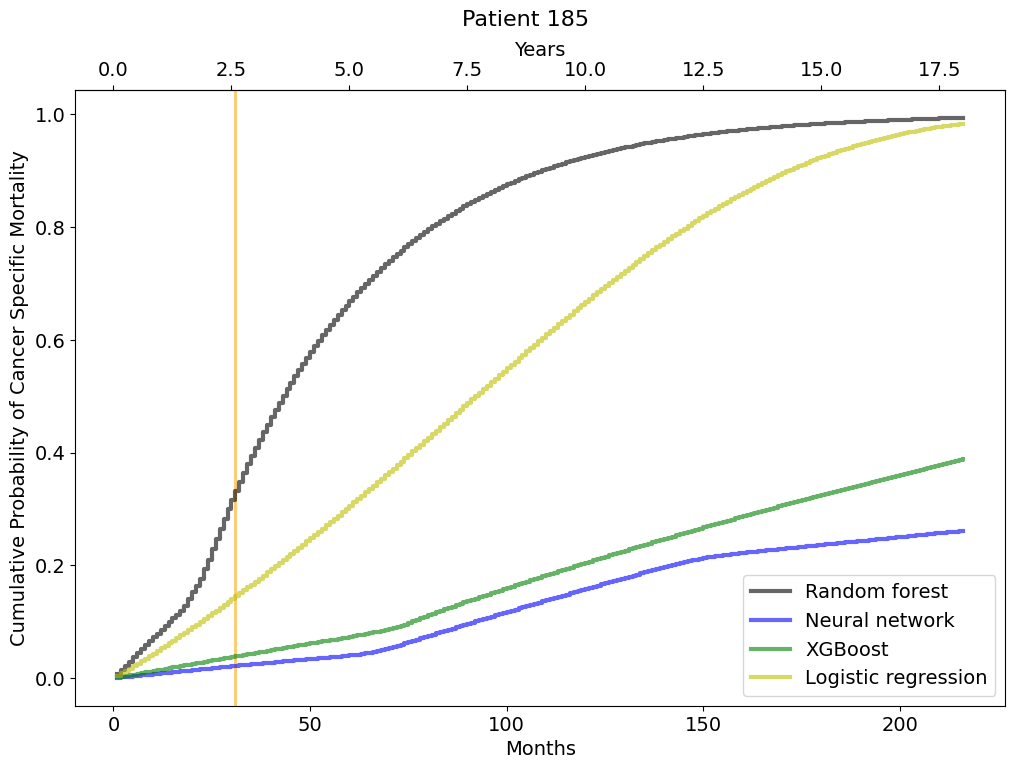

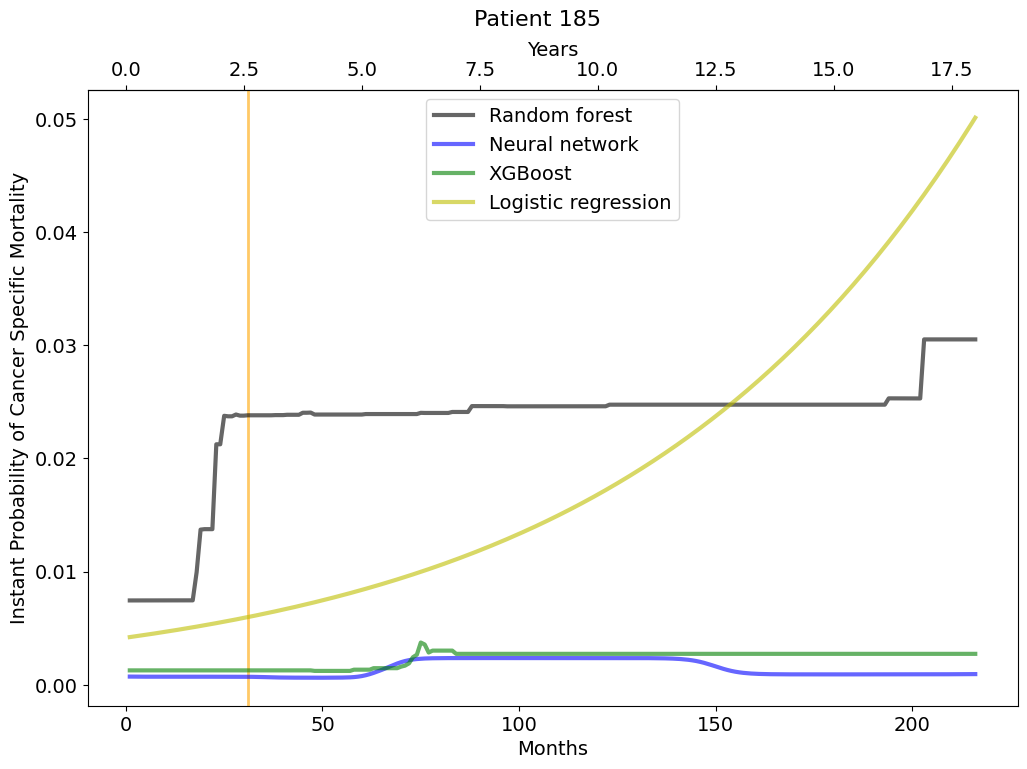

In [240]:
plot_single_patient_compare_models(df_lr=lr_df_test_predicted, df_rf=rf_df_test_predicted, df_xgb=xgb_df_test_predicted, df_nn=nn_df_test_predicted,
                                   patient_id=185, target_column='cancer_specific_mortality', fix_axis=False)